# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [ ]:
import warnings
warnings.simplefilter("ignore")
# warnings.filterwarnings("ignore")

# Data preparation

In [5]:
df = pd.read_csv("data/train.csv")
df

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,19214,749,757,143210,143219,17,4,4,2193,122,...,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,19215,723,735,2488529,2488541,231,17,26,27135,104,...,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,19216,6,31,1578055,1578129,780,114,98,71112,41,...,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,19217,9,18,1713172,1713184,126,13,26,14808,88,...,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1


In [6]:
df.drop("id", axis=1, inplace=True)

In [7]:
sns.set_theme(style="dark", palette="magma")
# sns.set_palette("dark")

In [8]:
def draw_heatmap(data, mask=None):
    plt.figure(figsize=(12, 12))
    sns.heatmap(data.corr(), mask=mask)
    plt.show()

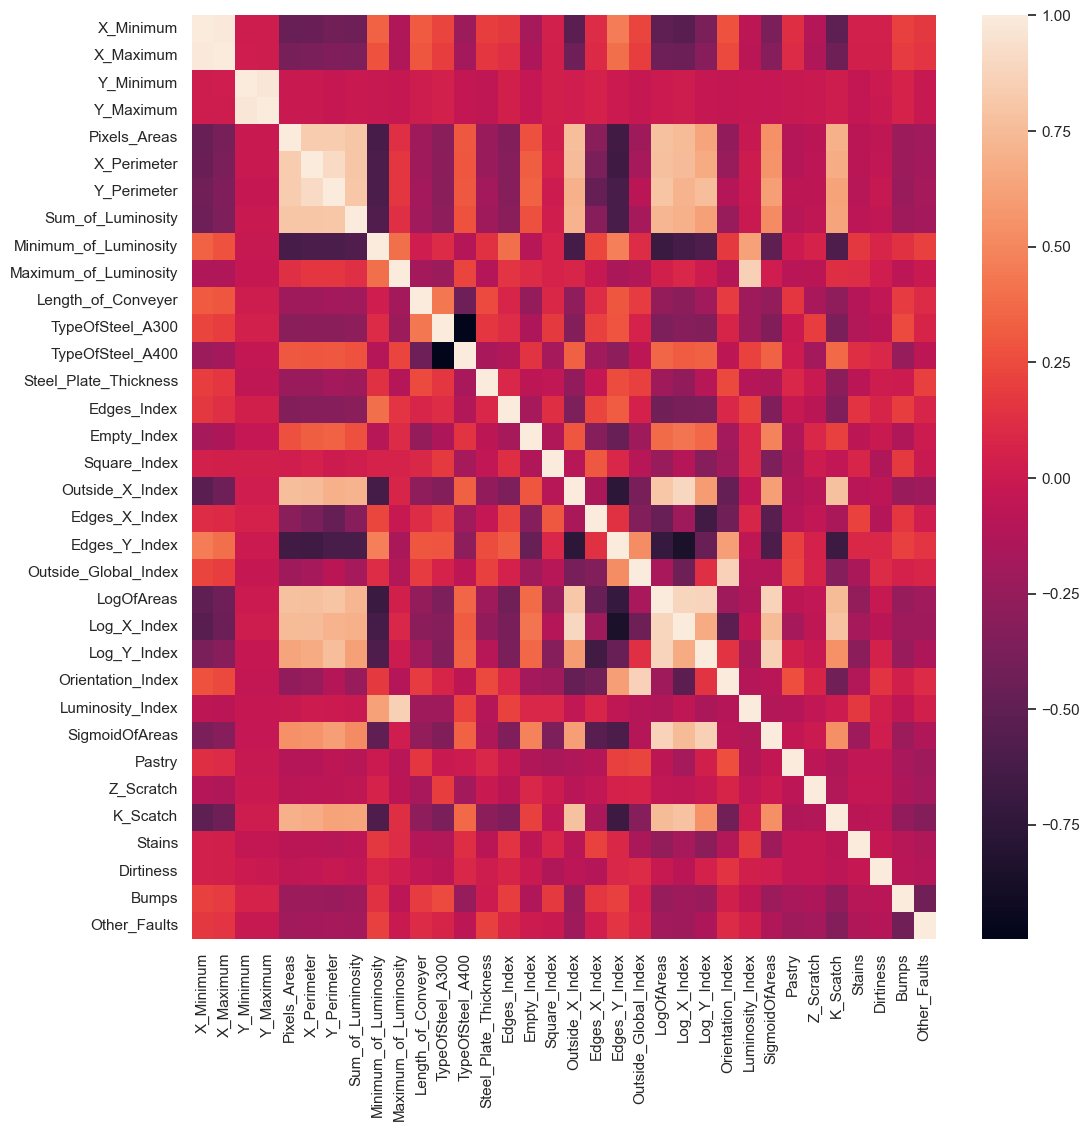

In [9]:
draw_heatmap(df)

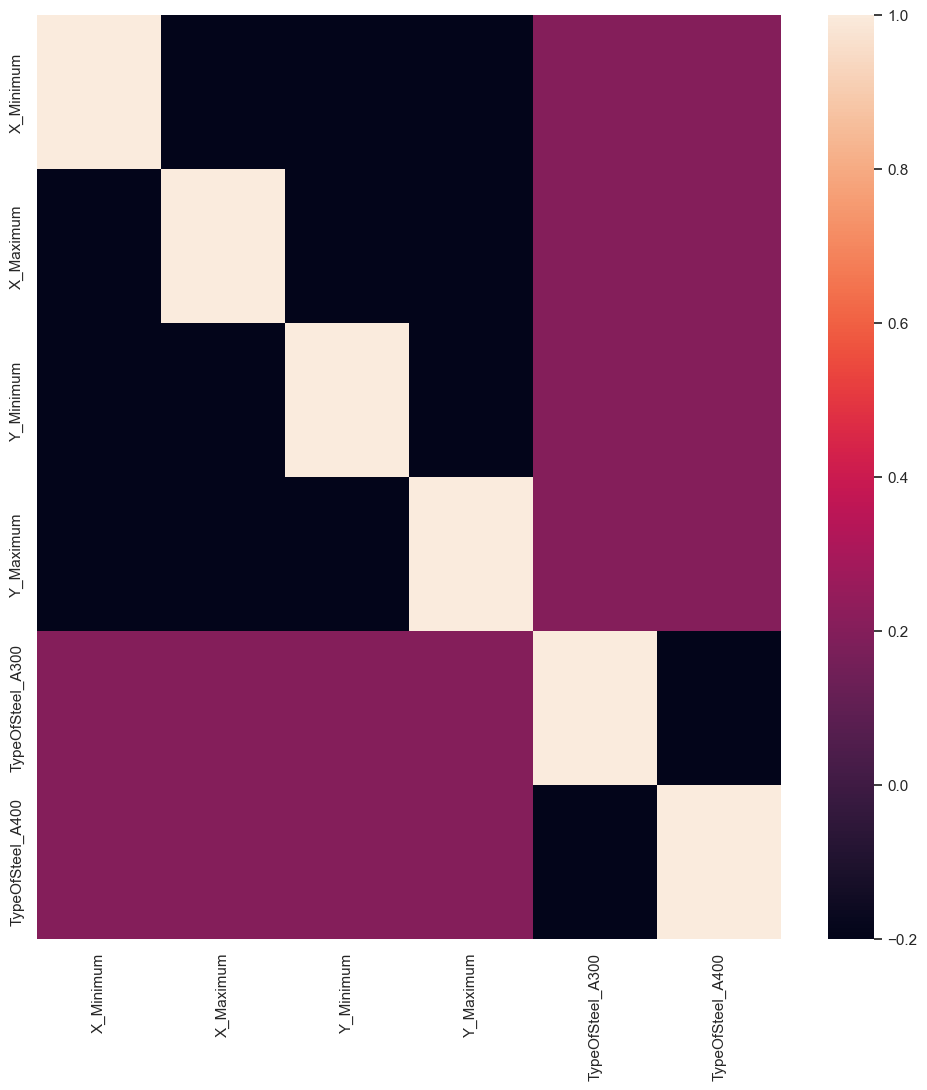

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,TypeOfSteel_A300,TypeOfSteel_A400
X_Minimum,0.000000,0.989767,0.000000,0.000000,0.000000,0.000000
X_Maximum,0.989767,0.000000,0.000000,0.000000,0.000000,0.000000
Y_Minimum,0.000000,0.000000,0.000000,0.969552,0.000000,0.000000
Y_Maximum,0.000000,0.000000,0.969552,0.000000,0.000000,0.000000
TypeOfSteel_A300,0.000000,0.000000,0.000000,0.000000,0.000000,-0.997732
TypeOfSteel_A400,0.000000,0.000000,0.000000,0.000000,-0.997732,0.000000


In [10]:
res = (
    df.corr()
    .where(lambda x: (abs(x) > 0.95) & (abs(x) != 1.0))
    .dropna(axis=1, how="all")
    .dropna(axis=0, how="all")
    .fillna(0)
)  # Не знаю, почему без fillna оно работает так плохо, но тем не менее
draw_heatmap(res)
res
# df.corr().any(lambda x: abs(x) > 0.8 || abs(x) != 1.0)
# df.loc[lambda x: abs(x)]
# df.loc[(df['Salary_in_1000']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]

In [11]:
df.drop(["TypeOfSteel_A400", "X_Minimum", "Y_Minimum"], axis=1, inplace=True)

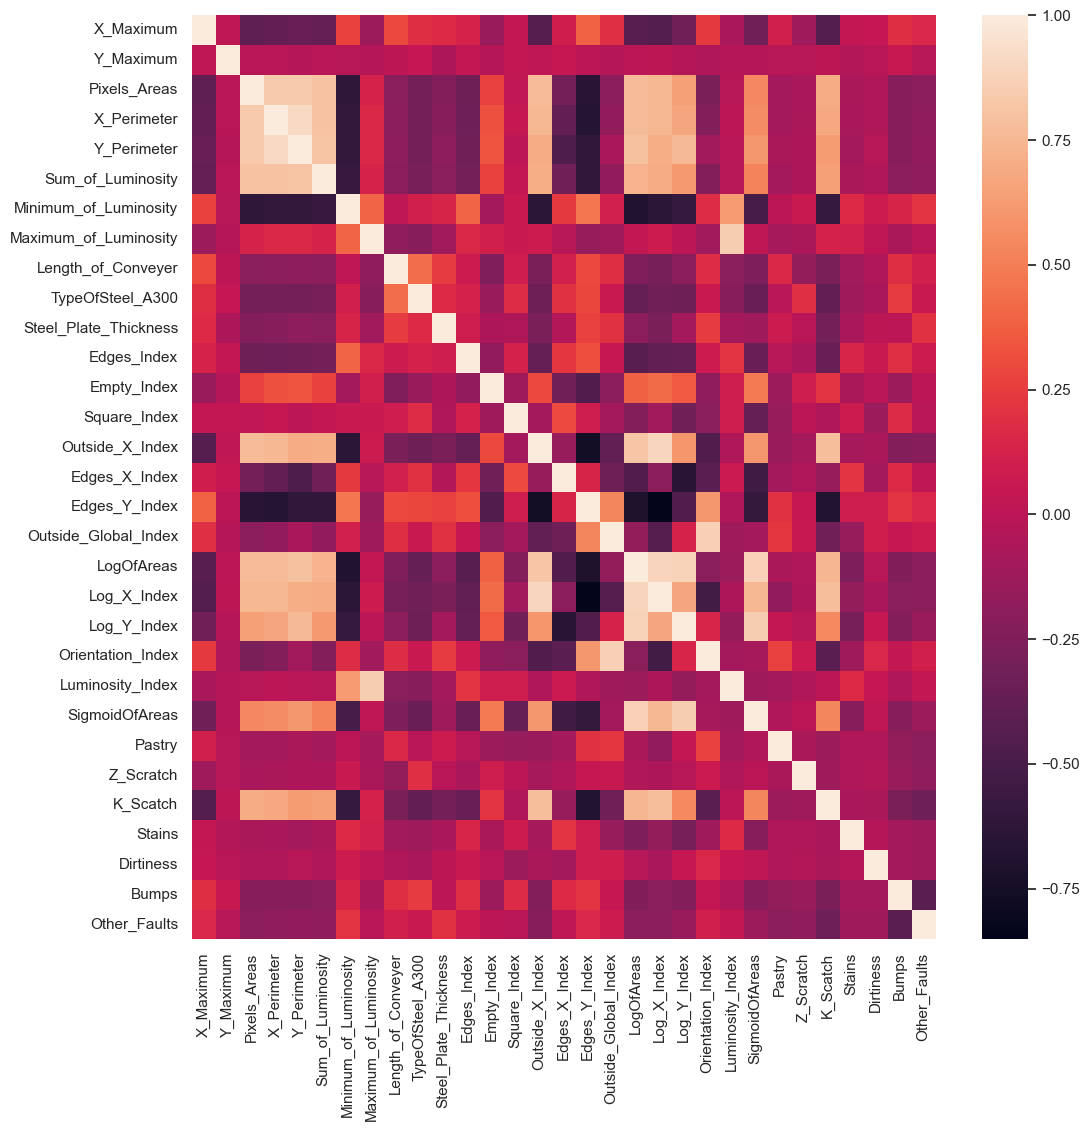

In [12]:
draw_heatmap(df)

In [13]:
target_columns = [
    "Pastry",
    "Z_Scratch",
    "K_Scatch",
    "Stains",
    "Dirtiness",
    "Bumps",
    "Other_Faults",
]
feature_columns = [cl for cl in df.columns if cl not in target_columns ]

In [14]:
feature_columns

['X_Maximum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas']

In [15]:
Y = df[target_columns]
X = df[feature_columns]

In [16]:
sc = StandardScaler()

X = sc.fit_transform(X)

In [17]:
Y.value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0         0       0          0      1               6540
                                                1      0               4761
                   1         0       0          0      0               3411
1       0          0         0       0          0      0               1465
0       1          0         0       0          0      0               1150
        0          0         0       0          0      0                818
                             1       0          0      0                568
                             0       1          0      0                485
                   1         0       0          0      1                 18
                                                1      0                  2
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42,
    # stratify=Y
)

# Models

## Functions

In [19]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [20]:
# Улучшенная функция оценки
def evaluate_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)
    y_pred_bin = (y_pred > 0.5).astype(int)
    
    # Рассчет метрик для каждого класса
    print(f"\n{'='*50}\nEvaluation for {model_name}\n{'='*50}")
    for i, col in enumerate(target_columns):
        print(f"\nMetrics for class {col}:")
        print(classification_report(y_test.iloc[:, i], y_pred_bin[:, i], zero_division=0))
    
    # Общие метрики
    print("\nOverall Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_bin))
    print("Precision (micro):", precision_score(y_test, y_pred_bin, average='micro'))
    print("Recall (micro):", recall_score(y_test, y_pred_bin, average='micro'))
    print("F1-Score (micro):", f1_score(y_test, y_pred_bin, average='micro'))
    
    # ROC-AUC для каждого класса
    roc_auc = roc_auc_score(y_test, y_pred, average=None)
    for i, col in enumerate(target_columns):
        print(f"ROC-AUC for {col}: {roc_auc[i]:.4f}")
    print(f"Mean ROC-AUC: {np.mean(roc_auc):.4f}")


In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

## Models

In [22]:
# Модель 1: Базовая FNN
model_fnn = Sequential(
    [
        Dense(24, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(24, activation="relu"),
        Dense(y_train.shape[1], activation="sigmoid"),
    ]
)

model_fnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [23]:
# Модель 2: Глубокая сеть с регуляризацией
model_deep = Sequential(
    [
        Dense(
            64,
            activation="relu",
            kernel_regularizer=l2(0.001),
            input_shape=(X_train.shape[1],),
        ),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(y_train.shape[1], activation="sigmoid"),
    ]
)

model_deep.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [24]:
# Модель 3: Широкая сеть
model_wide = Sequential(
    [
        Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dense(y_train.shape[1], activation="sigmoid"),
    ]
)

model_wide.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
# Модель 4: Сеть с другим оптимизатором
model_rmsprop = Sequential(
    [
        Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(y_train.shape[1], activation="sigmoid"),
    ]
)

model_rmsprop.compile(
    optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]
)

In [26]:
# Обучение всех моделей
models = {
    "Basic FNN": model_fnn,
    "Deep Regularized": model_deep,
    "Wide Network": model_wide,
    "RMSprop Model": model_rmsprop,
}

## Evaluation


Training Basic FNN
Epoch 1/150


193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2816 - loss: 0.5229 - val_accuracy: 0.5115 - val_loss: 0.2792
Epoch 2/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4968 - loss: 0.2775 - val_accuracy: 0.5174 - val_loss: 0.2572
Epoch 3/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5116 - loss: 0.2571 - val_accuracy: 0.5434 - val_loss: 0.2479
Epoch 4/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5359 - loss: 0.2478 - val_accuracy: 0.5580 - val_loss: 0.2419
Epoch 5/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5408 - loss: 0.2457 - val_accuracy: 0.5613 - val_loss: 0.2386
Epoch 6/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5447 - loss: 0.2401 - val_accuracy: 0.5610 - val_loss: 0.2364
Epoch 7/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5464 - loss: 0.2394 - val_accuracy: 0.5688 - val_loss: 0.2351
Epoch 8/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5534 - loss: 0.2360 - val_accuracy: 0.5629

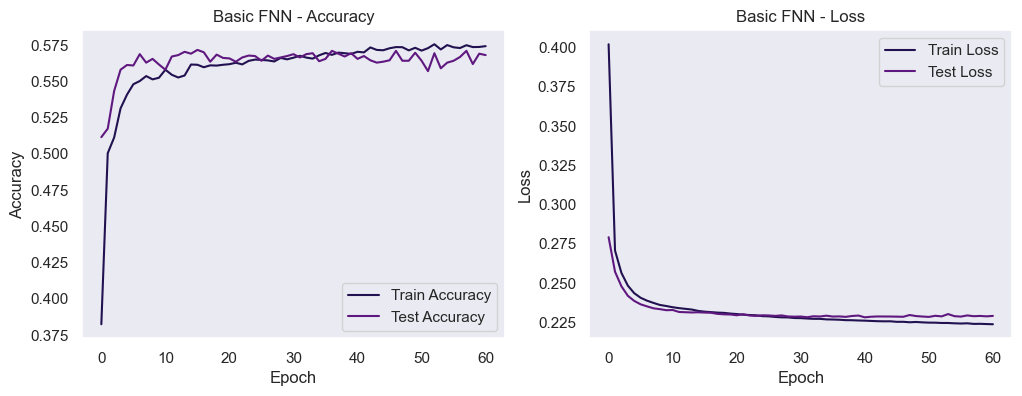


Training Deep Regularized
Epoch 1/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1865 - loss: 0.9341 - val_accuracy: 0.3460 - val_loss: 0.7441
Epoch 2/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2968 - loss: 0.8241 - val_accuracy: 0.3899 - val_loss: 0.7081
Epoch 3/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3271 - loss: 0.7710 - val_accuracy: 0.4159 - val_loss: 0.6767
Epoch 4/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3708 - loss: 0.7238 - val_accuracy: 0.4426 - val_loss: 0.6475
Epoch 5/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3721 - loss: 0.6915 - val_accuracy: 0.4686 - val_loss: 0.6197
Epoch 6/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3849 - loss: 0.6586 - val_accuracy: 0.4803 - val_loss: 0.5915
Epoch 7/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3966 - loss: 0.6315 - val_accuracy: 0.4920 - val_loss: 0.5612
Epoch 8/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.417

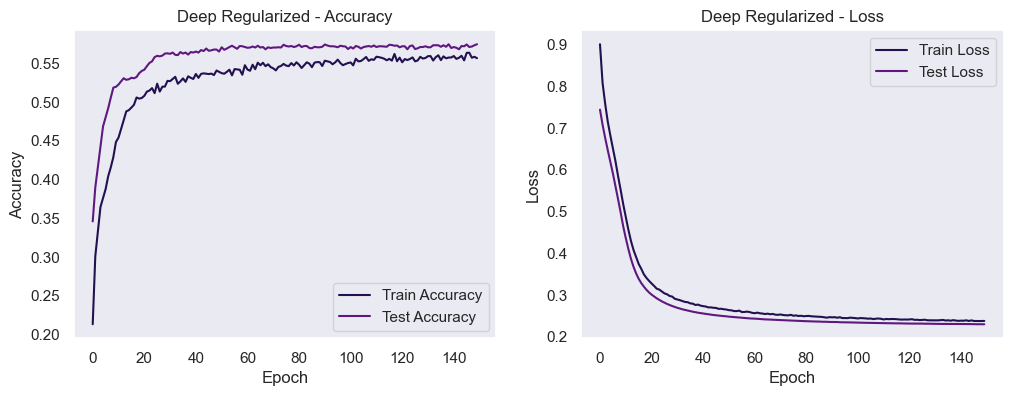


Training Wide Network
Epoch 1/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3570 - loss: 0.4140 - val_accuracy: 0.5307 - val_loss: 0.2504
Epoch 2/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5159 - loss: 0.2570 - val_accuracy: 0.5535 - val_loss: 0.2379
Epoch 3/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5287 - loss: 0.2476 - val_accuracy: 0.5535 - val_loss: 0.2347
Epoch 4/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5400 - loss: 0.2416 - val_accuracy: 0.5655 - val_loss: 0.2329
Epoch 5/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5435 - loss: 0.2403 - val_accuracy: 0.5659 - val_loss: 0.2313
Epoch 6/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5538 - loss: 0.2370 - val_accuracy: 0.5652 - val_loss: 0.2305
Epoch 7/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5531 - loss: 0.2387 - val_accuracy: 0.5711 - val_loss: 0.2299
Epoch 8/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5488 - 

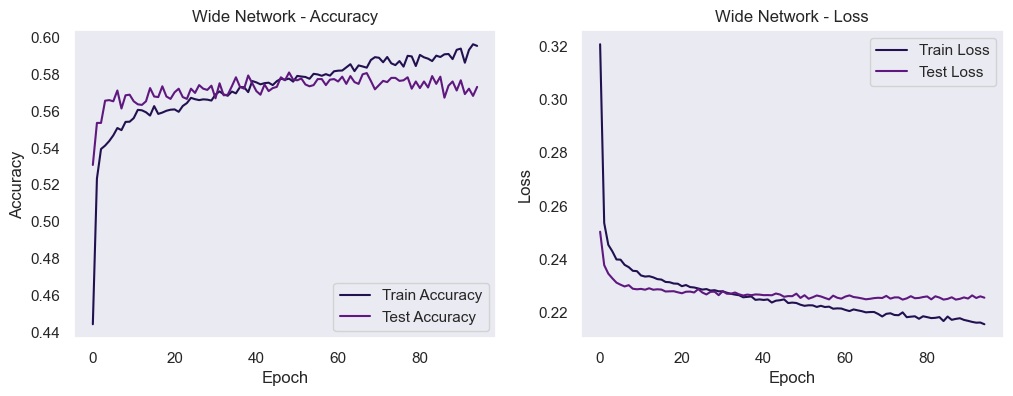


Training RMSprop Model
Epoch 1/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3389 - loss: 0.4505 - val_accuracy: 0.5288 - val_loss: 0.2506
Epoch 2/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5174 - loss: 0.2592 - val_accuracy: 0.5525 - val_loss: 0.2385
Epoch 3/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5385 - loss: 0.2452 - val_accuracy: 0.5597 - val_loss: 0.2352
Epoch 4/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5310 - loss: 0.2475 - val_accuracy: 0.5652 - val_loss: 0.2334
Epoch 5/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5375 - loss: 0.2428 - val_accuracy: 0.5662 - val_loss: 0.2322
Epoch 6/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5481 - loss: 0.2420 - val_accuracy: 0.5626 - val_loss: 0.2323
Epoch 7/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5391 - loss: 0.2407 - val_accuracy: 0.5642 - val_loss: 0.2312
Epoch 8/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5555 -

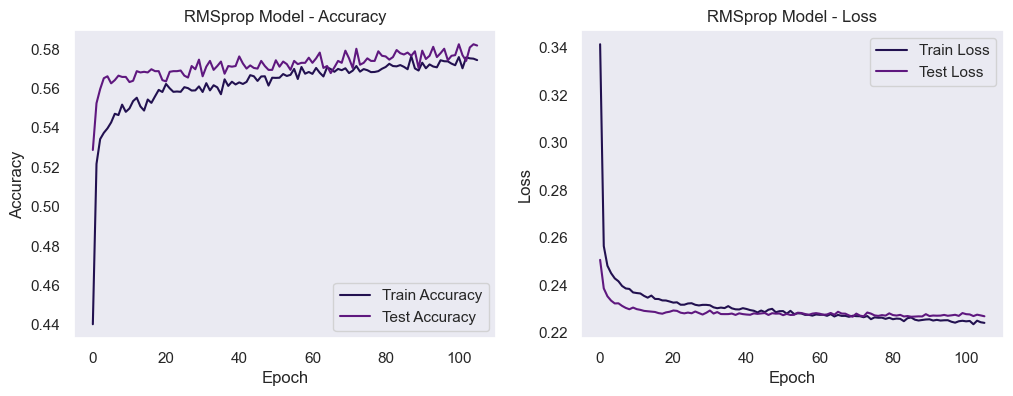

In [27]:
histories = {}
for name, model in models.items():
    print(f"\nTraining {name}")
    history = model.fit(
        X_train,
        y_train,
        epochs=150,
        batch_size=64,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stop],
    )
    histories[name] = history
    plot_results(history, name)



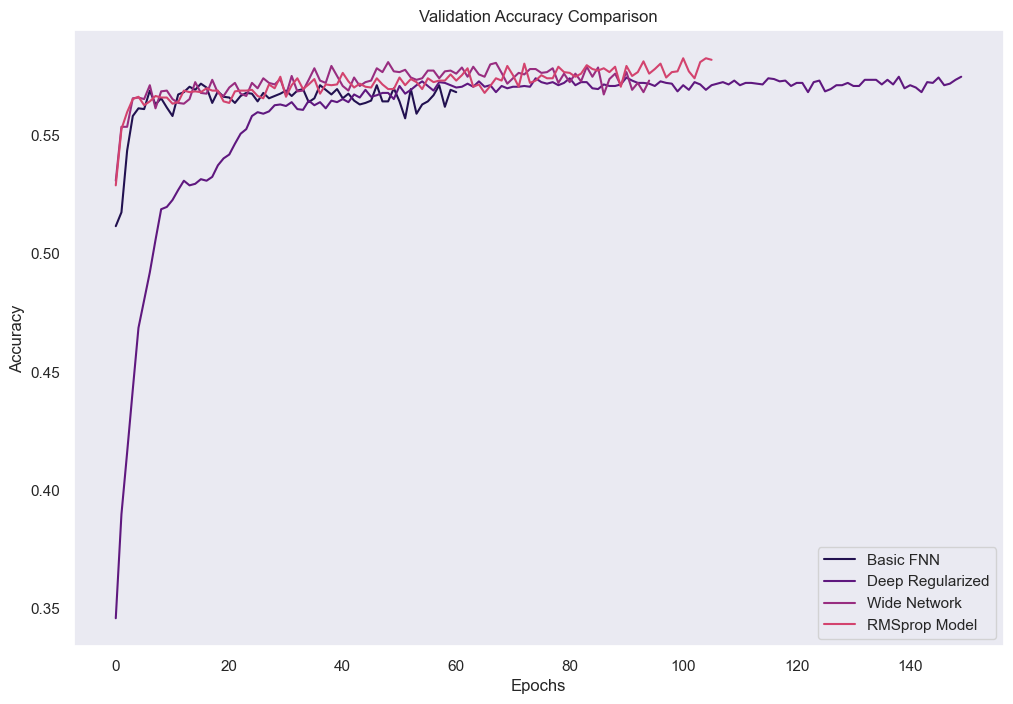

In [28]:
# Сравнение моделей
plt.figure(figsize=(12, 8))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Оценка всех моделей
for name, model in models.items():
    evaluate_model(model, X_test, y_test, model_name=name)
    model.save(f"models/{name.replace(' ', '_')}.keras")

# Вывод лучшей модели
best_model_name = max(
    histories.items(),
    key=lambda x: max(x[1].history['val_accuracy'])
)[0]
print(f"\nBest model: {best_model_name}")

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Evaluation for Basic FNN

Metrics for class Pastry:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3543
           1       0.41      0.05      0.08       301

    accuracy                           0.92      3844
   macro avg       0.67      0.52      0.52      3844
weighted avg       0.88      0.92      0.89      3844


Metrics for class Z_Scratch:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3624
           1       0.61      0.39      0.48       220

    accuracy                           0.95      3844
   macro avg       0.78      0.69      0.72      3844
weighted avg       0.94      0.95      0.95      3844


Metrics for class K_Scatch:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3162
           1       0.89      0.90      0.90       682

    accuracy                 